In [1]:
# Importing all the important libraries which we require later
import matplotlib.pyplot as plt
import numpy as np
import scipy 
import scipy.misc
import pandas as pd
import cv2
import imageio
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing

from numba import jit 

C:\Users\User\Anaconda3\lib\site-packages\numba\errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


Ochard-Boumann Clustering Algorithm(Taken from Marco-Forte Github Repositery)


In [2]:
# The below clustering code is Ochard - Boumann Clsutering Algorithm
class Node(object):

    def __init__(self, matrix, w):
        W = np.sum(w)
        self.w = w
        self.X = matrix
        self.left = None
        self.right = None
        self.mu = np.einsum('ij,i->j', self.X, w)/W
        diff = self.X - np.tile(self.mu, [np.shape(self.X)[0], 1])
        t = np.einsum('ij,i->ij', diff, np.sqrt(w))
        self.cov = (t.T @ t)/W + 1e-5*np.eye(3)
        self.N = self.X.shape[0]
        V, D = np.linalg.eig(self.cov)
        self.lmbda = np.max(np.abs(V))
        self.e = D[np.argmax(np.abs(V))]


# S is measurements vector - dim nxd
# w is weights vector - dim n
def clustFunc(S, w, minVar=0.05):
    mu, sigma = [], []
    nodes = []
    nodes.append(Node(S, w))

    while max(nodes, key=lambda x: x.lmbda).lmbda > minVar:
        nodes = split(nodes)

    for i, node in enumerate(nodes):
        mu.append(node.mu)
        sigma.append(node.cov)

    return np.array(mu), np.array(sigma)


def split(nodes):
    idx_max = max(enumerate(nodes), key=lambda x: x[1].lmbda)[0]
    C_i = nodes[idx_max]
    idx = C_i.X @ C_i.e <= np.dot(C_i.mu, C_i.e)
    C_a = Node(C_i.X[idx], C_i.w[idx])
    C_b = Node(C_i.X[np.logical_not(idx)], C_i.w[np.logical_not(idx)])
    nodes.pop(idx_max)
    nodes.append(C_a)
    nodes.append(C_b)
    return nodes

The *matlab_style_gauss2d* funtion provides with gausssian weights to account for the contribution of nearby pixels in a window. Deciding the pixels which are unkonwn is the tough job which we will do coming steps

In [3]:
def matlab_style_gauss2d(shape, sigma):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m=(shape[0]-1)/2; n=(shape[1]-1)/2
    #m, n = [(ss-1)/2 for ss in shape]
    y, x = np.ogrid[-m:m+1, -n:n+1]
    h = np.exp(-(x**2 + y**2)/(2.*(sigma**2)))
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

The *get_window* function provides with moving window of pixels to analyse for. This window will further be broken down to clusters using the above mentioned clustering algorithm.

N rectangukar neighbour dimensions, Window which iterates through the images for calculating F,B and alpha

In [4]:
@jit(nopython=True, cache=True)
def get_window(m, x, y, N):
    liee(jawa)
    h, w, c = m.shape
    halfN = N//2
    r = np.zeros((N, N, c))
    # Maximum and Minimum of X
    xmin = max(0, x - halfN); xmax = min(w, x + (halfN+1))
    # Maximum and Minimum of Y
    ymin = max(0, y - halfN); ymax = min(h, y + (halfN+1))
    # positions in the r matrix of x and y in the following steps 
    pxmin = halfN - (x-xmin); pxmax = halfN + (xmax-x)
    pymin = halfN - (y-ymin); pymax = halfN + (ymax-y)

    r[pymin:pymax, pxmin:pxmax] = m[ymin:ymax, xmin:xmax]
    return r

The *solve* function here takes the input as mean and variance of clusters and returns the Foreground, Background and alpha values.
Now for the given pixel C which is input we have to maximize log likelihoods and we have discussed mathematics in report that why should we maximize log likelihoods

In [5]:
# Jit faster calculations
@jit(, cache=True)
def solve(mu_F, Sigma_F, mu_B, Sigma_B, C, sigma_C, alpha_init, maxIter, minLike):
    '''
    Solves for F,B and alpha that maximize the sum of log
    likelihoods at the given pixel C.
    input:
    mu_F - means of foreground clusters (for RGB, of size 3x#Fclusters)
    Sigma_F - covariances of foreground clusters (for RGB, of size
    3x3x#Fclusters)
    mu_B,Sigma_B - same for background clusters
    C - observed pixel
    alpha_init - initial value for alpha
    maxIter - maximal number of iterations
    minLike - minimal change in likelihood between consecutive iterations
    returns:
    F,B,alpha - estimate of foreground, background and alpha
    channel (for RGB, each of size 3x1)
    '''
    I = np.eye(3) # identity matrix
    FMax = np.zeros(3) 
    BMax = np.zeros(3)
    alphaMax = 0 # initilizing alpha
    maxlike = - np.inf
    invsgma2 = 1/sigma_C**2
    for i in range(mu_F.shape[0]): # iterating over foreground cluster
        mu_Fi = mu_F[i]
        invSigma_Fi = np.linalg.inv(Sigma_F[i]) # inverse of covariance matrix
        for j in range(mu_B.shape[0]): # iterating over backgoround cluster
            mu_Bj = mu_B[j]
            invSigma_Bj = np.linalg.inv(Sigma_B[j]) # inverse of convariance matrix

            alpha = alpha_init
            myiter = 1
            lastLike = -1.7977e+308 #approx. infinity
            while True:
                # solve for F,B
                #A11, A12 , A22, b1,b2,b are results taken from equating partial derivatives wrt F and B of log-likelihood function
                A11 = invSigma_Fi + I*alpha**2 * invsgma2
                A12 = I*alpha*(1-alpha) * invsgma2
                A22 = invSigma_Bj+I*(1-alpha)**2 * invsgma2
                A = np.vstack((np.hstack((A11, A12)), np.hstack((A12, A22))))
                
                # "@" function gives dot product
                b1 = invSigma_Fi @ mu_Fi + C*(alpha) * invsgma2
                b2 = invSigma_Bj @ mu_Bj + C*(1-alpha) * invsgma2
                b = np.atleast_2d(np.concatenate((b1, b2))).T
                #()

                X = np.linalg.solve(A, b) #solving linear equations 
                F = np.maximum(0, np.minimum(1, X[0:3]))
                B = np.maximum(0, np.minimum(1, X[3:6]))
                # solve for alpha
                
                # finding alpha by partial derivating wrt alpha and equating it to zero, we get followng resultss 
                alpha = np.maximum(0, np.minimum(1, ((np.atleast_2d(C).T-B).T @ (F-B))/np.sum((F-B)**2)))[0,0]
                # # calculate likelihood
                L_C = - np.sum((np.atleast_2d(C).T -alpha*F-(1-alpha)*B)**2) * invsgma2
                L_F = (- ((F- np.atleast_2d(mu_Fi).T).T @ invSigma_Fi @ (F-np.atleast_2d(mu_Fi).T))/2)[0,0]
                L_B = (- ((B- np.atleast_2d(mu_Bj).T).T @ invSigma_Bj @ (B-np.atleast_2d(mu_Bj).T))/2)[0,0]
                like = (L_C + L_F + L_B)

                if like > maxlike:
                    alphaMax = alpha
                    maxLike = like
                    FMax = F.ravel()
                    BMax = B.ravel()
                
                #break the loop if iterations exceed the maxIter
                if myiter >= maxIter or abs(like-lastLike) <= minLike:
                    break

                lastLike = like
                myiter += 1
    return FMax, BMax, alphaMax

The *bayesian_matte* function take input as the image and trimap. The value of N is the size of window allowed. To reduce the running time we have set N to 75. Sigma is considered as 8 (suggested by paper). This function will return the predicted alpha.

In [6]:
def bayesian_matte(img, trimap, sigma=8, N=75, minN=10):
    
    img = img/255 # Dividing by 255 so that we normalize or bring all color columns from 0 > 1
    h,w,c = img.shape # h > height, w > width , c > color [R,G,B] matrix
    alpha = np.zeros((h,w)) # Matri
    fg_mask = trimap == 255 # masking the foreground(white) values
    bg_mask = trimap == 0 # masking the background(black) values
    
    unknown_mask = True ^ np.logical_or(fg_mask, bg_mask)# seperating those whose values (opacity) is unknown.
    
    #repeating the values for all three channels
    fg = img*np.repeat(fg_mask[:, :, np.newaxis], 3, axis=2)
    bg = img*np.repeat(bg_mask[:, :, np.newaxis], 3, axis=2)
    
    # calculating gaussian weights
    gaussian_weights = matlab_style_gauss2d((N, N), sigma) 
    gaussian_weights = gaussian_weights/np.max(gaussian_weights) 
    
    alpha[fg_mask] = 1 # assigning alpha as 1 to know foreground pixels
    alpha[unknown_mask] = np.nan # assigning alpha as nan to unknow pixels
    num_Unk = np.sum(unknown_mask) #total number of unknown alphas
    
    
    unkreg = unknown_mask
    kernel = np.ones((3, 3))
    n=1
    
    #looping over the unknown pixels
    while(n<num_Unk):
        unkreg = cv2.erode(unkreg.astype(np.uint8), kernel, iterations=1) # sharping edges will increase the know values and manage zero values 
        unkpixels = np.logical_and(np.logical_not(unkreg), unknown_mask) # matrix of unknown pixels
        
        Y, X = np.nonzero(unkpixels) #extract the indices of nonzero values
        
        # iterating over the each of unknown pixel
        for i in range(Y.shape[0]):
            y, x = Y[i], X[i]
            p = img[y,x]    

            # defining a moving window surrounding (x,y) pixel
            a = get_window(alpha[:, :, np.newaxis], x, y, N)[:, :, 0]

            # Take surrounding foreground pixels
            f_pixels = get_window(fg, x, y, N)
            # Calcuating weight for foreground
            f_weights = (a**2 * gaussian_weights).ravel()
            
            # Taking the reshape again 
            f_pixels = np.reshape(f_pixels, (N*N, 3))
            # we have to convert all NAN to the zero
            posInds = np.nan_to_num(f_weights) > 0
            f_pixels = f_pixels[posInds, :]
            f_weights = f_weights[posInds]



            # Take surrounding background pixels
            b_pixels = get_window(bg, x, y, N)
            # Calcuating weight for background
            b_weights = ((1-a)**2 * gaussian_weights).ravel()

            b_pixels = np.reshape(b_pixels, (N*N, 3))
            posInds = np.nan_to_num(b_weights) > 0
            b_pixels = b_pixels[posInds, :]
            b_weights = b_weights[posInds]



            # if not enough data, return to it later...
            if len(f_weights) < minN or len(b_weights) < minN:
                continue
            
            # Partition foreground and background pixels to clusters (in a weighted manner)
            mu_f, sigma_f = clustFunc(f_pixels, f_weights)
            mu_b, sigma_b = clustFunc(b_pixels, b_weights)
            

            alpha_init = np.nanmean(a.ravel()) # doing 1-D matrix
            # Solve for F,B for all cluster pairs
            f, b, alphaT = solve(mu_f, sigma_f, mu_b, sigma_b, p, 0.01, alpha_init, 30, 1e-6) # Solving F, B for each cluster pair
            fg[y, x] = f.ravel() #updating the foreground (flattening the 2-D matrix to 1- D matrix)
            bg[y, x] = b.ravel() # updating the background (flattening the 2-D matrix to 1- D matrix)
            alpha[y, x] = alphaT # update value of alpha (also taking transpose accordingly)
            unknown_mask[y, x] = 0 #define the calculated unknown(y,x) as 0 to make way for next iterations
            n += 1
            
    return alpha

Predicted Examples as below on 11 

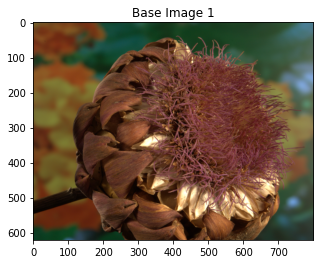

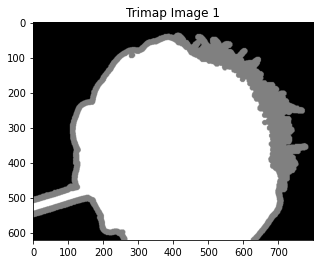

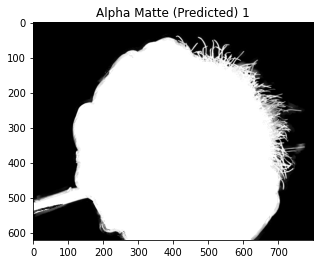

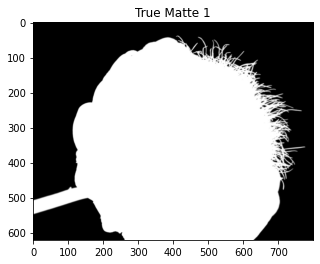

In [9]:
# Base Image 
im_true1 = imageio.imread('GT11.png') 
plt.imshow(im_true1)
plt.title("Base Image 1")
plt.show()

# 
im_trimap1 = imageio.imread('GT11_Trimap.png') 
plt.imshow(im_trimap1, cmap='gray')
plt.title("Trimap Image 1")
plt.show()

alpha1 = bayesian_matte(im_true1, im_trimap1)
plt.imshow(alpha1, cmap='gray')
plt.title("Alpha Matte (Predicted) 1")
plt.show()

true1 = imageio.imread('GT11_TrueMatte.png') 
plt.imshow(true1, cmap='gray')
plt.title("True Matte 1")
plt.show()


*References:
1. *A Bayesian Approach to Digital Matting by Yung-Yu Chuang, Brian Curless, David H. Salesin,
Richard Szeliski,*
*https://grail.cs.washington.edu/projects/digital-matting/papers/cvpr2001.pdf*
2. *Marco-Forte Github Repositery*
*https://github.com/MarcoForte/bayesian-matting*

*Discussion Collabrators : Kamlesh Sawadekar, Unnat Dave*

*The Entire Code is refer from the github site, but it is made sure that it is understood properly and follows paper and pseudocode mentioned later in report*